# Description of the project
This is my first practical project in Machine Learning, using the Titanic example of Kaggle (https://www.kaggle.com/c/titanic). The goal is to create a model to predict the survival probability of passengers.

In [683]:
# Import the relevant packages
import pylab as py
import pandas as pd # Pandas handles statistical data
import sklearn # Machine learning package
import sklearn.linear_model
import sklearn.neural_network
import sklearn.ensemble
import sklearn.metrics
import sklearn.preprocessing
import time,datetime
import numpy.random as random
%matplotlib inline

In [68]:
"""
A simple FiveThirtyEight palette for Seaborn plots.
"""

import seaborn as sns
import matplotlib.pyplot as plt

if False:
    five_thirty_eight = [
        "#30a2da",
        "#fc4f30",
        "#e5ae38",
        "#6d904f",
        "#8b8b8b",
    ]

    sns.set_palette(five_thirty_eight)
    sns.palplot(sns.color_palette())
    plt.show()

# Read and clean data
Read data and analyse which features are important.

In [69]:
# Read training and test data using Pandas
data = pd.read_csv("data/train.csv")
data_test = pd.read_csv("data/test.csv")

In [70]:
# Print a description of the files
print(data.info(),data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

# Visualize data

Some of the information, such as 'PassengerID' and 'Ticket', is useless for the purpose of survaviblity prediction.

'Survived' is the y-label, the dependant variable. To optimize algorithms, we convert it to uint8

In [71]:
data['Survived'] = data['Survived'].astype('uint8')

## Gender and class

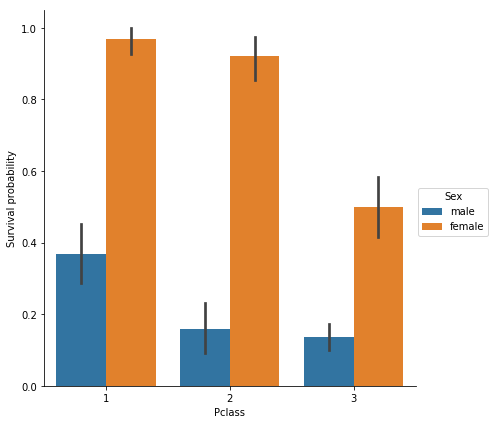

In [72]:
"""
Example available at
https://seaborn.pydata.org/examples/factorplot_bars.html
"""
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=data, size=6, kind="bar")
#g.despine(left=True)
g.set_ylabels("Survival probability")

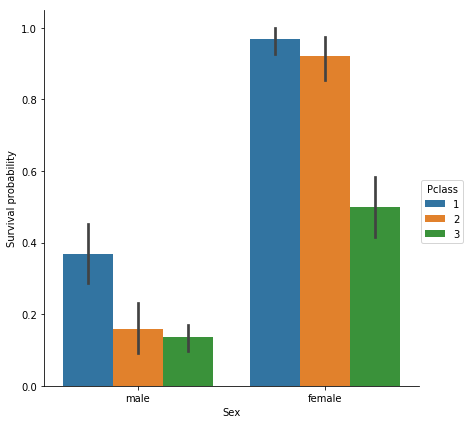

In [73]:
g = sns.factorplot(x="Sex", y="Survived", hue="Pclass", data=data, size=6, kind="bar")
#g.despine(left=True)
g.set_ylabels("Survival probability")

An interesting fact appears. For women, being in 2nd class is almost as good as being in 1st class, while 3rd class is much worse. For men, being in 2nd class is almost as bad as being in 3rd class, while 1st class is much better. For this reason, I will group this two features in one.

In [74]:
def function(x):
    for sex in ['male','female']:
        for clas in [1,2,3]:
            if x['Sex'] == sex and x['Pclass'] == clas:
                return sex[0].upper() + str(clas)
data['SexClass'] = data.apply(function,axis=1)
data_test['SexClass'] = data_test.apply(function,axis=1)

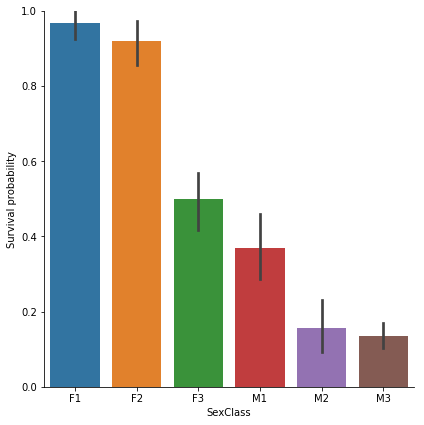

In [75]:
g = sns.factorplot(x="SexClass", y="Survived", data=data, size=6, kind="bar",order=sorted(data['SexClass'].unique()))
#g.despine(left=True)
g.set_ylabels("Survival probability")
g.set(ylim=(0, 1))

## Age
Age is represented as a float and there are many missing values.

In [76]:
data['Age'] = data.apply(lambda x:int(x['Age']) if not py.isnan(x['Age']) else py.nan,axis=1)

<Container object of 3 artists>

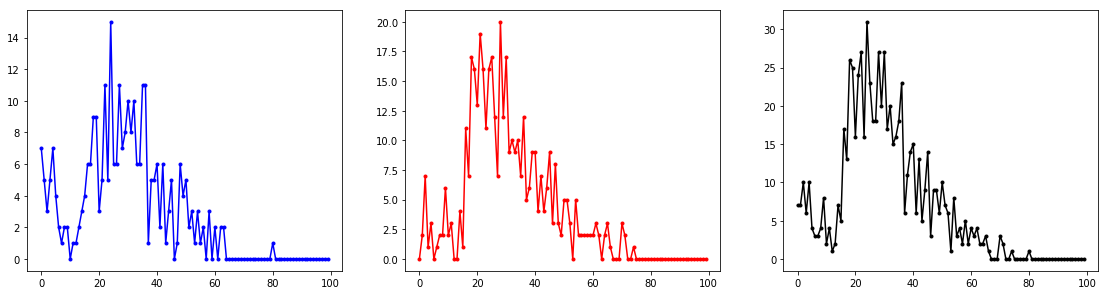

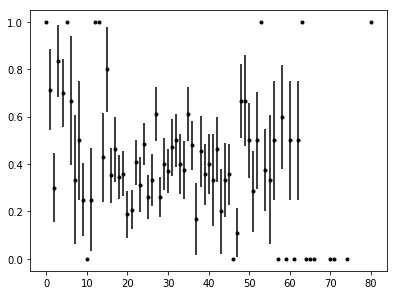

In [77]:
"""
Example available at
https://seaborn.pydata.org/examples/horizontal_barplot.html
"""
histogram_ages = {}
for age in range(0,100):
    survived = len(data[(data['Age']==age)&(data['Survived']==1)])
    dead = len(data[(data['Age']==age)&(data['Survived']==0)])
    histogram_ages[age] = {'Survived':survived,'Died':dead,'Total':survived+dead,'Age':age}
histogram_ages = pd.DataFrame.from_dict(histogram_ages,orient='index')
#g = sns.barplot(y='Survived',x='Age',data=histogram_ages)
fig,ax = py.subplots(1,3,figsize=(3*6.4,1*4.8))
ax[0].plot(histogram_ages['Age'],histogram_ages['Survived'],'b.-')
ax[1].plot(histogram_ages['Age'],histogram_ages['Died'],'r.-')
ax[2].plot(histogram_ages['Age'],histogram_ages['Total'],'k.-')
histogram_ages['SurvProb'] = histogram_ages.apply(lambda x:x['Survived']*1.0/x['Total'] if x['Total']>0 else py.nan,axis=1)
histogram_ages['SurvProb_std'] = histogram_ages.apply(lambda x:py.sqrt(x['SurvProb']*(1-x['SurvProb'])/x['Total']) if x['Total']>0 else py.nan,axis=1)
fig2,ax2 = py.subplots(1,1,figsize=(1*6.4,1*4.8))
ax2.errorbar(histogram_ages['Age'],histogram_ages['SurvProb'],yerr=histogram_ages['SurvProb_std'],fmt='k.')

Age does not seem to be very predictive, except for a child/adult/senior division.
There is a sharp increse at the number of people at 16 year's old, suggesting that 16-year-olds can be considered adults. There's also a shift in the probability of survival at 48-years-ols, suggesting that 48-year-olds can be considered seniors.

(-5, 70)

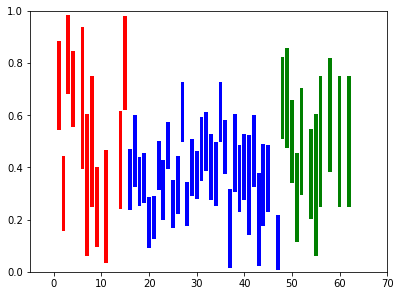

In [78]:
childrenLimit = 16
seniorLimit = 48
fig3,ax3 = py.subplots(1,1,figsize=(1*6.4,1*4.8))
children = histogram_ages[histogram_ages['Age']<childrenLimit]
ax3.bar(py.array(children['Age']),
        height=2*py.array(children['SurvProb_std']),
        bottom=py.array(children['SurvProb'])-py.array(children['SurvProb_std']),
        color='r')
adult = histogram_ages[(histogram_ages['Age']>=childrenLimit)&(histogram_ages['Age']<seniorLimit)]
ax3.bar(py.array(adult['Age']),
        height=2*py.array(adult['SurvProb_std']),
        bottom=py.array(adult['SurvProb'])-py.array(adult['SurvProb_std']),
        color='b')
senior = histogram_ages[histogram_ages['Age']>=seniorLimit]
ax3.bar(py.array(senior['Age']),
        height=2*py.array(senior['SurvProb_std']),
        bottom=py.array(senior['SurvProb'])-py.array(senior['SurvProb_std']),
        color='g')
ax3.set_ylim(-0.00,1.00)
ax3.set_xlim(-5,70)

In [79]:
def categorizeAgeGroup(row):
    if py.isnan(row['Age']):
        return 'unknown'
    if row['Age'] < childrenLimit:
        return 'child'
    elif row['Age'] < seniorLimit:
        return 'adult'
    else:
        return 'senior'
data['Agegroup'] = data.apply(categorizeAgeGroup,axis=1)
data_test['Agegroup'] = data_test.apply(categorizeAgeGroup,axis=1)

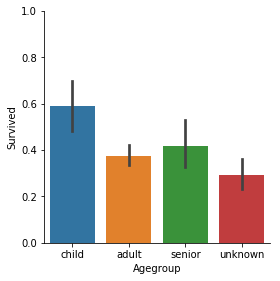

In [80]:
order = ['child','adult','senior','unknown']
g = sns.factorplot(x='Agegroup',y='Survived',data=data,order=order,kind='bar')
g.set(ylim=(0, 1))


The male/female dynamics in children are very different than in adults. I will now create a new category where male/female difference only makes sense for adults.

In [668]:
def function(x):
    for sex in ['male','female']:
        for clas in [1,2,3]:
            if x['Sex'] == sex and x['Pclass'] == clas:
                if py.isnan(x['Age']) or x['Age']>=childrenLimit:
                    return sex[0].upper() + str(clas)
                else:
                    return 'C' + str(clas)
data['SexClassAge'] = data.apply(function,axis=1)
data_test['SexClassAge'] = data_test.apply(function,axis=1)

In [670]:
data['SexClassAge'].value_counts()

M3    319
M1    119
F3    114
M2     99
F1     91
F2     66
C3     58
C2     19
C1      6
Name: SexClassAge, dtype: int64

## Family members
People travelling alone died in a much higher rate than people travelling with family.

In [104]:
def getFamilyStatusComplete(row):
    if (row['SibSp']==0) & (row['Parch']==0):
        return 'Alone'
    elif (row['SibSp']==0) & (row['Parch']>0):
        return 'With parents'
    elif (row['SibSp']>0) & (row['Parch']==0):
        return 'With siblings'
    elif (row['SibSp']>0) & (row['Parch']>0):
        return 'With parents and siblings'
def getFamilyStatusSimplified(row):
    if (row['SibSp']==0) & (row['Parch']==0):
        return 'Alone'
    else:
        return 'With family'
data['FamilyStatusComplete'] = data.apply(getFamilyStatusComplete,axis=1)
data['FamilyStatusSimplified'] = data.apply(getFamilyStatusSimplified,axis=1)
data_test['FamilyStatusComplete'] = data_test.apply(getFamilyStatusComplete,axis=1)
data_test['FamilyStatusSimplified'] = data_test.apply(getFamilyStatusSimplified,axis=1)

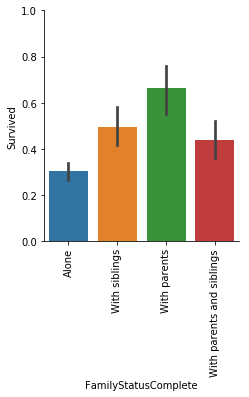

In [82]:
order = ['Alone','With siblings','With parents','With parents and siblings']
g = sns.factorplot(x='FamilyStatusComplete',y='Survived',data=data,order=order,kind='bar')
g.set(ylim=(0, 1))
g.set_xticklabels(rotation=90)

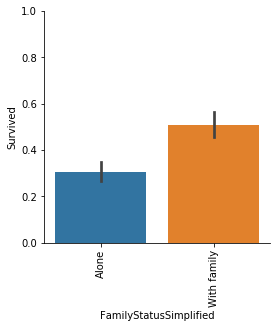

In [83]:
order = ['Alone','With family']
g = sns.factorplot(x='FamilyStatusSimplified',y='Survived',data=data,order=order,kind='bar')
g.set(ylim=(0, 1))
g.set_xticklabels(rotation=90)

## Fare

In [84]:
data.apply(lambda x:py.log(x['Fare']+1),axis=1).describe()

count    891.000000
mean       2.962246
std        0.969048
min        0.000000
25%        2.187218
50%        2.737881
75%        3.465736
max        6.240917
dtype: float64

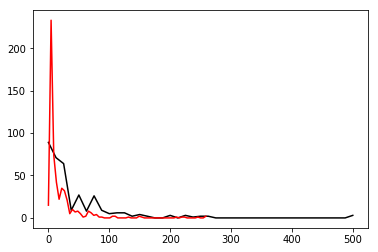

In [87]:
histogram_survived = py.histogram(data[data['Survived']==1]['Fare'],bins='auto')
histogram_died = py.histogram(data[data['Survived']==0]['Fare'],bins='auto')
fig,ax = py.subplots()
ax.plot(histogram_survived[1][:-1],histogram_survived[0],'k-')
ax.plot(histogram_died[1][:-1],histogram_died[0],'r-')

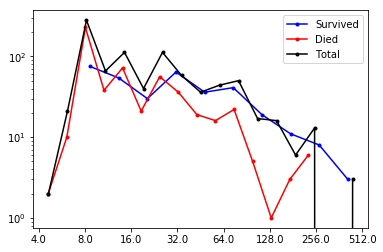

In [105]:
data['LogFare'] = data.apply(lambda x:py.log2(x['Fare']+0.0) if x['Fare']>0 else None,axis=1)
data_test['LogFare'] = data_test.apply(lambda x:py.log2(x['Fare']+0.0) if x['Fare']>0 else None,axis=1)
arr = data[data['Survived']==1]['LogFare']
histogram_survived = py.histogram(arr[~py.isnan(arr)],bins='auto')
arr = data[data['Survived']==0]['LogFare']
histogram_died = py.histogram(arr[~py.isnan(arr)],bins='auto')
arr = data['LogFare']
histogram_total = py.histogram(arr[~py.isnan(arr)],bins='auto')
fig,ax = py.subplots()
xarray = 0.5 * py.array(histogram_survived[1][:-1]) + 0.5 * py.array(histogram_survived[1][1:])
ax.plot(xarray,histogram_survived[0],'b.-',label='Survived')
xarray = 0.5 * py.array(histogram_died[1][:-1]) + 0.5 * py.array(histogram_died[1][1:])
ax.plot(xarray,histogram_died[0],'r.-',label='Died')
xarray = 0.5 * py.array(histogram_total[1][:-1]) + 0.5 * py.array(histogram_total[1][1:])
ax.plot(xarray,histogram_total[0],'k.-',label='Total')
ax.set_xticklabels([2**x for x in ax.get_xticks()])
ax.set_yscale('log')
ax.legend()

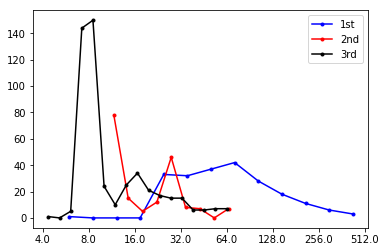

In [106]:
arr = data[data['Pclass']==1]['LogFare']
histogram_1st = py.histogram(arr[~py.isnan(arr)],bins='auto')
arr = data[data['Pclass']==2]['LogFare']
histogram_2nd = py.histogram(arr[~py.isnan(arr)],bins='auto')
arr = data[data['Pclass']==3]['LogFare']
histogram_3rd = py.histogram(arr[~py.isnan(arr)],bins='auto')
fig,ax = py.subplots()
xarray = 0.5 * py.array(histogram_1st[1][:-1]) + 0.5 * py.array(histogram_1st[1][1:])
ax.plot(xarray,histogram_1st[0],'b.-',label='1st')
xarray = 0.5 * py.array(histogram_2nd[1][:-1]) + 0.5 * py.array(histogram_2nd[1][1:])
ax.plot(xarray,histogram_2nd[0],'r.-',label='2nd')
xarray = 0.5 * py.array(histogram_3rd[1][:-1]) + 0.5 * py.array(histogram_3rd[1][1:])
ax.plot(xarray,histogram_3rd[0],'k.-',label='3rd')
ax.set_xticklabels([2**x for x in ax.get_xticks()])
ax.set_yscale('linear')
ax.legend()

Fare seems to be highly correlated with class and so would not bring much additional predictive power.

## Port of embarkment
Passengers were embarked in three ports. Some missing values will be associated to the dominant port

In [112]:
fillna = data['Embarked'].mode()
data['Embarked'] = data['Embarked'].fillna(fillna)
data_test['Embarked'] = data_test['Embarked'].fillna(fillna)

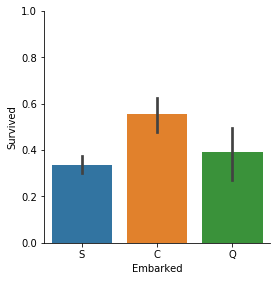

In [117]:
g = sns.factorplot(x='Embarked',y='Survived',data=data,kind='bar')
g.set(ylim=(0,1))

It seems that people who embarked in the alternative ports did better.

## Cabin
'Cabin' has too many missing values, so it'll be dropped

In [16]:
# 'Cabin' has too many missing values, so it'll be dropped
data.drop(['Cabin'],axis=1,inplace=True)
data_test.drop(['Cabin'],axis=1,inplace=True)

## Name
Possible features associated with that
* Title (strongly correlated with Sex)
* Frequency of last name (large families travelling together?)
* Given a nickname?
* Given a travel companion?

In [533]:
print data['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
10                       Sandstrom, Miss. Marguerite Rut
11                              Bonnell, Miss. Elizabeth
12                        Saundercock, Mr. William Henry
13                           Andersson, Mr. Anders Johan
14                  Vestrom, Miss. Hulda Amanda Adolfina
15                      Hewlett, Mrs. (Mary D Kingcome) 
16                                  Rice, Master. Eugene
17                          Wil

In [597]:
def processName(name):
    out = {}
    commaSeparate = name.split(',')
    out['LastName'] = commaSeparate[0]
    out['Title'] = commaSeparate[1].split()[0]
    out['GivenName'] = ' '.join(commaSeparate[1].split()[1:])
    return out
namesProcess = data.apply(lambda x:processName(x['Name']),axis=1)
data['NameTitle'] = [x['Title'] for x in namesProcess]
data['LastName'] = [x['LastName'] for x in namesProcess]
data['GivenName'] = [x['GivenName'] for x in namesProcess]
namesProcess = data_test.apply(lambda x:processName(x['Name']),axis=1)
data_test['NameTitle'] = [x['Title'] for x in namesProcess]
data_test['LastName'] = [x['LastName'] for x in namesProcess]
data_test['GivenName'] = [x['GivenName'] for x in namesProcess]




In [598]:
surnames = pd.concat([data,data_test])['LastName'].value_counts()
data['SurnameFrequency'] = data.apply(lambda x:surnames[x['LastName']],axis=1)
data_test['SurnameFrequency'] = data_test.apply(lambda x:surnames[x['LastName']],axis=1)

In [599]:
data['Nickname'] = data.apply(lambda x:'"' in x['Name'],axis=1)
data['Companion'] = data.apply(lambda x:'(' in x['Name'],axis=1)
data_test['Nickname'] = data_test.apply(lambda x:'"' in x['Name'],axis=1)
data_test['Companion'] = data_test.apply(lambda x:'(' in x['Name'],axis=1)

1     447
2     168
3     121
4      62
6      45
5      19
11     16
8      10
7       3
Name: SurnameFrequency, dtype: int64

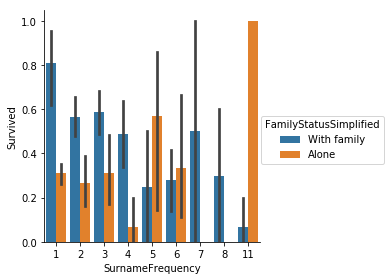

In [600]:
g = sns.factorplot(x='SurnameFrequency',y='Survived',hue='FamilyStatusSimplified',data=data,kind='bar')
data['SurnameFrequency'].value_counts()

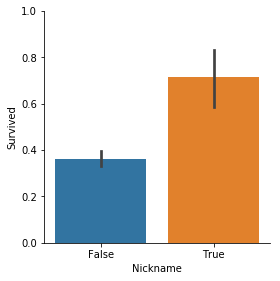

In [601]:
g = sns.factorplot(x='Nickname',y='Survived',data=data,kind='bar')
data['Nickname'].value_counts()
g.set(ylim=(0,1))

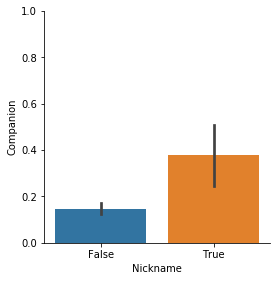

In [584]:
g = sns.factorplot(x='Nickname',y='Companion',data=data,kind='bar')
data['Companion'].value_counts()
g.set(ylim=(0,1))

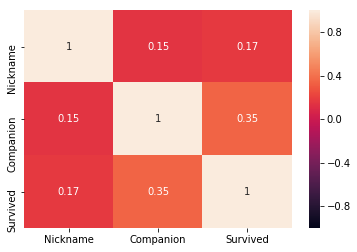

In [590]:
corr = data[['Nickname','Companion','Survived']].corr()
g = sns.heatmap(corr,vmin=-1,vmax=1,annot=True)

# Choice of features
We get to the important part of choosing the features.
* 'Sexclass': a combined feature that has very high predictive power.
* 'Agegroup': child/adult/senior
* 'FamilyStatusComplete' or 'FamilyStatusSimplified'
* 'Embarked'
All of these are categorical variables


In [675]:
def genDummies(dataset):
    dummies = []
    mode = dataset['SexClassAge'].mode()
    dummies.append(pd.get_dummies(dataset['SexClassAge']).drop([mode[0]],axis=1).rename(columns=lambda x:'SexClassAge_'+str(x)))
    mode = dataset['Agegroup'].mode()
    dummies.append(pd.get_dummies(dataset['Agegroup']).drop([mode[0]],axis=1).rename(columns=lambda x:'Agegroup_'+str(x)))
    mode = dataset['FamilyStatusComplete'].mode()
    dummies.append(pd.get_dummies(dataset['FamilyStatusComplete']).drop([mode[0]],axis=1).rename(columns=lambda x:'FamilyStatus_'+str(x)))
    mode = dataset['Embarked'].mode()
    dummies.append(pd.get_dummies(dataset['Embarked']).drop([mode[0]],axis=1).rename(columns=lambda x:'Embarked_'+str(x)))
    return dummies
newData = pd.concat(genDummies(data),axis=1)
newTest = pd.concat(genDummies(data_test),axis=1)
newData = pd.concat([newData,data['Nickname'].astype('uint8'),data['Companion'].astype('uint8')],axis=1)
newTest = pd.concat([newTest,data_test['Nickname'].astype('uint8'),data_test['Companion'].astype('uint8')],axis=1)

newData = pd.concat([newData,data['Survived'].astype('uint8')],axis=1)


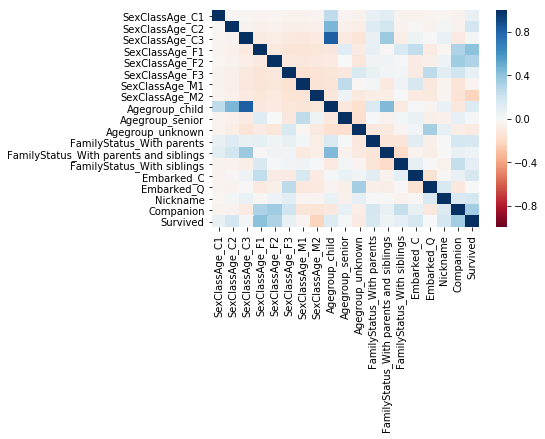

In [676]:
#corr = newData.drop('Survived',axis=1).corr()
corr = newData.drop([],axis=1).corr()
g = sns.heatmap(corr,vmin=-1,vmax=1,annot=False,cmap='RdBu')

In [626]:
newData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
SexClass_F1                               891 non-null uint8
SexClass_F2                               891 non-null uint8
SexClass_F3                               891 non-null uint8
SexClass_M1                               891 non-null uint8
SexClass_M2                               891 non-null uint8
Agegroup_child                            891 non-null uint8
Agegroup_senior                           891 non-null uint8
Agegroup_unknown                          891 non-null uint8
FamilyStatus_With parents                 891 non-null uint8
FamilyStatus_With parents and siblings    891 non-null uint8
FamilyStatus_With siblings                891 non-null uint8
Embarked_C                                891 non-null uint8
Embarked_Q                                891 non-null uint8
Survived                                  891 non-null uint8
Nickname                                 

# Using logistic regression

In [677]:
random.seed(0)
indices = newData.index
trainIndices = sorted(random.choice(indices,replace=False,size=int(len(newData.index)*0.7)))
testIndices = [x for x in indices if x not in trainIndices]
trainSet = newData.loc[trainIndices]
testSet = newData.loc[testIndices]

In [678]:
logisticRegression = sklearn.linear_model.LogisticRegression(C=1e-1)
# Fit training set
logisticRegression.fit(trainSet.drop('Survived',axis=1),trainSet['Survived'])
# Get training score
scoreTrain = logisticRegression.score(trainSet.drop('Survived',axis=1),trainSet['Survived'])
# Get test score
scoreTest = logisticRegression.score(testSet.drop('Survived',axis=1),testSet['Survived'])
print 'Train score: {:7.4f}'.format(scoreTrain)
print 'Test score: {:7.4f}'.format(scoreTest)


Train score:  0.8379
Test score:  0.7575


In [679]:
featureImportance = pd.DataFrame.from_dict({'coef':{x:y for x,y in zip(trainSet.drop('Survived',axis=1).columns,logisticRegression.coef_[0])}})
featureImportance['OddsRatio'] = featureImportance.apply(lambda x:py.exp(x['coef']),axis=1)
featureImportance

,coef,OddsRatio
Agegroup_child,0.557848,1.746910
Agegroup_senior,0.041028,1.041881
Agegroup_unknown,-0.343117,0.709555
Companion,0.733404,2.082157
Embarked_C,0.394483,1.483616
Embarked_Q,0.122625,1.130460
FamilyStatus_With parents,0.288216,1.334046
FamilyStatus_With parents and siblings,-0.063504,0.938470
FamilyStatus_With siblings,0.087870,1.091846
Nickname,0.696275,2.006265


In [680]:
neuralNetwork = sklearn.neural_network.MLPClassifier()
# Fit training set
neuralNetwork.fit(trainSet.drop('Survived',axis=1),trainSet['Survived'])
# Get training score
scoreTrain = neuralNetwork.score(trainSet.drop('Survived',axis=1),trainSet['Survived'])
# Get test score
scoreTest = neuralNetwork.score(testSet.drop('Survived',axis=1),testSet['Survived'])
print 'Train score: {:7.4f}'.format(scoreTrain)
print 'Test score: {:7.4f}'.format(scoreTest)
predict = neuralNetwork.predict(newTest)

Train score:  0.8571
Test score:  0.7761


In [644]:
## Exporting output
output = neuralNetwork.predict(newTest)
timestring = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d%H%M')
csvFile = open('OutputTitanic_{}.csv'.format(timestring),'w')
csvFile.write('PassengerId,Survived\n')
for pid,out in zip(data_test['PassengerId'],output):
    csvFile.write('{:d},{:d}\n'.format(pid,out))
csvFile.close()

In [645]:
randomForest = sklearn.ensemble.RandomForestClassifier()
# Fit training set
randomForest.fit(trainSet.drop('Survived',axis=1),trainSet['Survived'])
# Get training score
scoreTrain = randomForest.score(trainSet.drop('Survived',axis=1),trainSet['Survived'])
# Get test score
scoreTest = randomForest.score(testSet.drop('Survived',axis=1),testSet['Survived'])
print 'Train score: {:7.4f}'.format(scoreTrain)
print 'Test score: {:7.4f}'.format(scoreTest)

Train score:  0.8571
Test score:  0.6667


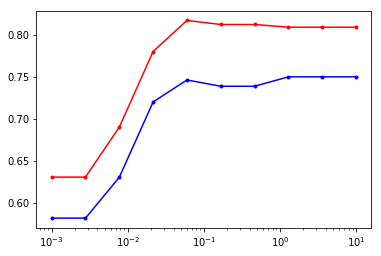

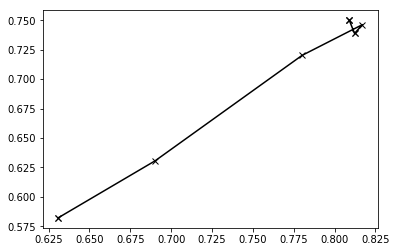

In [206]:
## Changing regularization parameter of logistic regression
def trainLogisticRegression(c):
    logreg = sklearn.linear_model.LogisticRegression(C=c)
    logreg.fit(trainSet.drop('Survived',axis=1),trainSet['Survived'])
    scoreTrain = logreg.score(trainSet.drop('Survived',axis=1),trainSet['Survived'])
    scoreTest = logreg.score(testSet.drop('Survived',axis=1),testSet['Survived'])
    return scoreTrain,scoreTest
#Crange = [1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1e0,3e0,1e1,3e1]
Crange = py.exp(py.linspace(py.log(1e-3),py.log(1e1),10))
scores = map(trainLogisticRegression,Crange)
fig,ax = py.subplots()
ax.plot(Crange,[x[0] for x in scores],'r.-',label='Train score')
ax.plot(Crange,[x[1] for x in scores],'b.-',label='Train score')
ax.set_xscale('log')
fig2,ax2 = py.subplots()
ax2.plot([x[0] for x in scores],[x[1] for x in scores],'kx-')

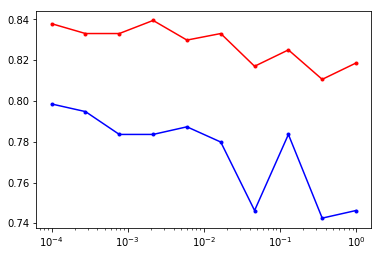

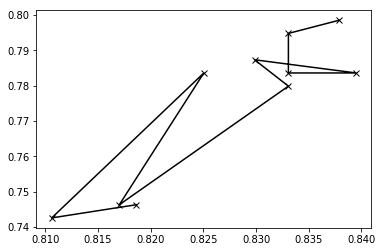

In [216]:
## Changing regularization parameter of logistic regression
def trainNeuralNetwork(c):
    logreg = sklearn.neural_network.MLPClassifier(alpha=c)
    logreg.fit(trainSet.drop('Survived',axis=1),trainSet['Survived'])
    scoreTrain = logreg.score(trainSet.drop('Survived',axis=1),trainSet['Survived'])
    scoreTest = logreg.score(testSet.drop('Survived',axis=1),testSet['Survived'])
    return scoreTrain,scoreTest
#Crange = [1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1e0,3e0,1e1,3e1]
Crange = py.exp(py.linspace(py.log(1e-4),py.log(1e0),10))
scores = map(trainNeuralNetwork,Crange)
fig,ax = py.subplots()
ax.plot(Crange,[x[0] for x in scores],'r.-',label='Train score')
ax.plot(Crange,[x[1] for x in scores],'b.-',label='Test score')
ax.set_xscale('log')
fig2,ax2 = py.subplots()
ax2.plot([x[0] for x in scores],[x[1] for x in scores],'kx-')

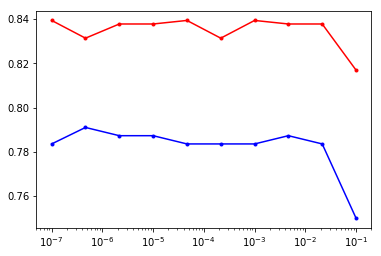

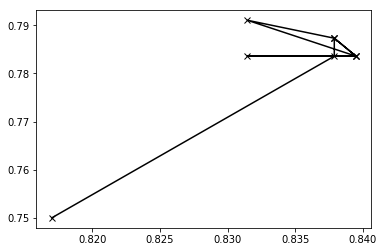

In [231]:
## Changing regularization parameter of logistic regression
def trainNeuralNetwork(c):
    logreg = sklearn.neural_network.MLPClassifier(activation='relu',alpha=c,max_iter=100,hidden_layer_sizes=300)
    logreg.fit(trainSet.drop('Survived',axis=1),trainSet['Survived'])
    scoreTrain = logreg.score(trainSet.drop('Survived',axis=1),trainSet['Survived'])
    scoreTest = logreg.score(testSet.drop('Survived',axis=1),testSet['Survived'])
    return scoreTrain,scoreTest
#Crange = [1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1e0,3e0,1e1,3e1]
Crange = py.exp(py.linspace(py.log(1e-7),py.log(1e-1),10))
scores = map(trainNeuralNetwork,Crange)
fig,ax = py.subplots()
ax.plot(Crange,[x[0] for x in scores],'r.-',label='Train score')
ax.plot(Crange,[x[1] for x in scores],'b.-',label='Test score')
ax.set_xscale('log')
#ax.set_ylim(0.7,0.9)
fig2,ax2 = py.subplots()
ax2.plot([x[0] for x in scores],[x[1] for x in scores],'kx-')

In [235]:
import sklearn.pipeline
help(sklearn.pipeline)

Help on module sklearn.pipeline in sklearn:

NAME
    sklearn.pipeline

FILE
    /Library/Python/2.7/site-packages/sklearn/pipeline.py

DESCRIPTION
    The :mod:`sklearn.pipeline` module implements utilities to build a composite
    estimator, as a chain of transforms and estimators.

CLASSES
    sklearn.base.TransformerMixin(__builtin__.object)
        FeatureUnion(_BasePipeline, sklearn.base.TransformerMixin)
    _BasePipeline(abc.NewBase)
        FeatureUnion(_BasePipeline, sklearn.base.TransformerMixin)
        Pipeline
    
    class FeatureUnion(_BasePipeline, sklearn.base.TransformerMixin)
     |  Concatenates results of multiple transformer objects.
     |  
     |  This estimator applies a list of transformer objects in parallel to the
     |  input data, then concatenates the results. This is useful to combine
     |  several feature extraction mechanisms into a single transformer.
     |  
     |  Parameters of the transformers may be set using its name and the parameter
   

In [251]:
neuralNetPipeline = sklearn.pipeline.Pipeline([
    ('neuralNetwork',sklearn.neural_network.MLPClassifier())
])

In [240]:
help(neuralNetPipeline.get_params)

Help on method get_params in module sklearn.pipeline:

get_params(self, deep=True) method of sklearn.pipeline.Pipeline instance
    Get parameters for this estimator.
    
    Parameters
    ----------
    deep: boolean, optional
        If True, will return the parameters for this estimator and
        contained subobjects that are estimators.
    
    Returns
    -------
    params : mapping of string to any
        Parameter names mapped to their values.



In [252]:
neuralNetPipeline.fit(trainSet.drop('Survived',axis=1),trainSet['Survived'])

Pipeline(steps=[('neuralNetwork', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

In [288]:
neuralNetPipeline.set_params(neuralNetwork__alpha=1e-3
                            ,neuralNetwork__activation='relu'
                            ,neuralNetwork__hidden_layer_sizes=(1000,1)
                            ,neuralNetwork__max_iter = 100000)
neuralNetPipeline.fit(trainSet.drop('Survived',axis=1),trainSet['Survived'])
print neuralNetPipeline.score(trainSet.drop('Survived',axis=1),trainSet['Survived'])
print neuralNetPipeline.score(testSet.drop('Survived',axis=1),testSet['Survived'])

0.369181380417
0.417910447761


/Library/Python/2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:565: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [297]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

#    def transform(self, X):
#        col_list = []
#        for c in self.cols:
#            col_list.append(X[:, c:c+1])
#        return np.concatenate(col_list, axis=1)
    def transform(self, X):
        return X[self.cols]

    def fit(self, X, y=None):
        return self

In [307]:
features = [x for x in newTest.columns if 'SexClass' in x or True]
neuralNetPipeline = sklearn.pipeline.Pipeline([
    ('featureChoice',ColumnExtractor(features)),
    ('neuralNetwork',sklearn.neural_network.MLPClassifier())
])

In [308]:
neuralNetPipeline.fit(trainSet.drop('Survived',axis=1),trainSet['Survived'])

Pipeline(steps=[('featureChoice', <__main__.ColumnExtractor object at 0x117f1be50>), ('neuralNetwork', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       lea...=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False))])

In [309]:
print neuralNetPipeline.score(trainSet.drop('Survived',axis=1),trainSet['Survived'])
print neuralNetPipeline.score(testSet.drop('Survived',axis=1),testSet['Survived'])

0.833065810594
0.794776119403


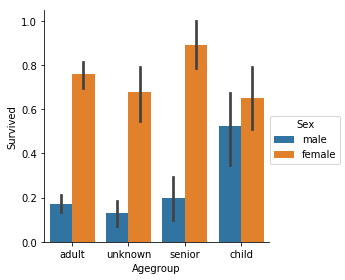

In [364]:
g = sns.factorplot(hue='Sex',y='Survived',x='Agegroup',data=data,kind='bar')

In [301]:
features

Index([u'SexClass_F1', u'SexClass_F2', u'SexClass_F3', u'SexClass_M1',
       u'SexClass_M2', u'Agegroup_child', u'Agegroup_senior',
       u'Agegroup_unknown', u'FamilyStatusSimplified_With family',
       u'Embarked_C', u'Embarked_Q'],
      dtype='object')

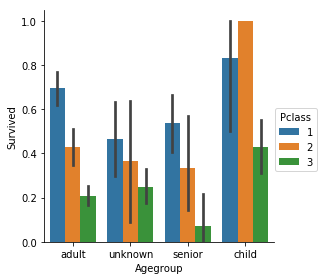

In [366]:
g = sns.factorplot(hue='Pclass',y='Survived',x='Agegroup',data=data,kind='bar')

# Using pipeline
The Pipeline function seems interesting to automatize some process.
First, it is useful to define a custom class to be able to choose specific features of a dataset.

In [485]:
"""
Based on
https://stackoverflow.com/questions/25250654/how-can-i-use-a-custom-feature-selection-function-in-scikit-learns-pipeline
"""
class ColumnExtractor(object):
    def __init__(self, features = None):
        self.features = list(features)
    def transform(self, X):
        if self.features is None:
            return X
        return X[self.features]
    def fit(self, X, y=None):
        return self
    def get_params(self,*args,**kwargs):
        return {'features':self.features}
    def set_params(self,features=None,*args,**kwargs):
        if features is not None:
            self.features = features
class IndexExtractor(object):
    def __init__(self, indices = None):
        if indices is not None:
            self.indices = list(indices)
        else:
            self.indices = None
    def transform(self, X):
        if self.indices is None:
            return X
        else:
            return X.loc[self.indices]
    def fit(self, X, y=None):
        return self
    def get_params(self,*args,**kwargs):
        return {'indices':self.indices}
    def set_params(self,indices=None,*args,**kwargs):
        if indices is not None:
            self.indices = indices

In [486]:
logisticRegression = sklearn.pipeline.Pipeline([
#    ('exampleChoice',IndexExtractor(indices)),
    ('featureChoice',ColumnExtractor(features)),
    ('model',sklearn.linear_model.LogisticRegression())
])
neuralNetwork = sklearn.pipeline.Pipeline([
#    ('exampleChoice',IndexExtractor(indices)),
    ('featureChoice',ColumnExtractor(features)),
    ('model',sklearn.neural_network.MLPClassifier())
])
randomForest = sklearn.pipeline.Pipeline([
#    ('exampleChoice',IndexExtractor(indices)),
    ('featureChoice',ColumnExtractor(features)),
    ('model',sklearn.ensemble.RandomForestClassifier())
])

In [508]:
def getErrorLogreg(sampleSize):
    trainSmall = trainSet.sample(sampleSize)
    features = trainSet.columns
    logisticRegression.set_params(
        featureChoice__features=[x for x in features if x!='Survived'],
        model__C = 1e-1,
        model__fit_intercept = True
    )
    logisticRegression.fit(trainSmall.drop('Survived',axis=1),trainSmall['Survived'])
    trainError = logisticRegression.score(trainSmall.drop('Survived',axis=1),trainSmall['Survived'])
    testError = logisticRegression.score(testSet.drop('Survived',axis=1),testSet['Survived'])
    return trainError,testError
def getErrorNeural(sampleSize):
    trainSmall = trainSet.sample(sampleSize)
    features = trainSet.columns
    neuralNetwork.set_params(
        featureChoice__features=[x for x in features if x!='Survived'],
        model__alpha = 1e+0,
    )
    neuralNetwork.fit(trainSmall.drop('Survived',axis=1),trainSmall['Survived'])
    trainError = neuralNetwork.score(trainSmall.drop('Survived',axis=1),trainSmall['Survived'])
    testError = neuralNetwork.score(testSet.drop('Survived',axis=1),testSet['Survived'])
    return trainError,testError

(0, 0.5)

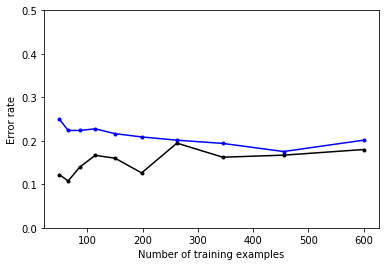

In [511]:
sampleLimits = (50,600)
sampleSize = py.exp(py.linspace(py.log(sampleLimits[0]),py.log(sampleLimits[1]),10))
sampleSize = map(int,sampleSize)
errors = map(getErrorNeural,sampleSize)
fig,ax = py.subplots()
ax.plot(sampleSize,[1-x[0] for x in errors],'k.-')
ax.plot(sampleSize,[1-x[1] for x in errors],'b.-')
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Error rate')
ax.set_ylim(0,0.5)

In [379]:
random.choice(trainSet.index,replace=False,size=100)

array([175, 878, 401, 818, 811, 890, 841, 264,  51, 164, 502,  63,  26,
       449, 530, 436, 853, 266, 533,  37, 157, 145, 738, 828, 531, 276,
       833, 346, 384, 283, 824, 229, 827, 648, 395, 263, 838, 860, 545,
       165, 478, 694, 743, 503, 689, 852, 524, 160, 208, 156, 669, 881,
       575, 671, 831, 262, 467, 761, 495, 839, 535, 649, 403, 816, 511,
       471, 799, 588, 435, 681, 622, 338,  93, 126, 198, 674,  69, 692,
       219, 657, 570, 105, 225, 322, 764, 628, 222, 737, 513, 787, 462,
       210, 308, 272, 252, 857, 439, 120, 344, 678])

In [460]:
Cgrid = [1e-4,3e-4,1e-3,3e-3,1e-2,3e-2,1e-1,3e-1,1e+0,3e+0,1e+1,3e+1]
grid = sklearn.model_selection.GridSearchCV(logisticRegression,{'model__C':Cgrid},cv=50)

In [461]:
grid.fit(trainSet.drop('Survived',axis=1),trainSet['Survived'])

/Library/Python/2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator ColumnExtractor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator ColumnExtractor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator ColumnExtractor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/base.py:122: DeprecationWarning: Estimator ColumnExtractor modifies parameters in __init__. This behavior is deprecated as o

GridSearchCV(cv=50, error_score='raise',
       estimator=Pipeline(steps=[('featureChoice', <__main__.ColumnExtractor object at 0x117169a90>), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'model__C': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

0.74626865671641796

In [466]:
grid.cv_results_['mean_test_score']

array([ 0.63081862,  0.63081862,  0.63081862,  0.63081862,  0.71589085,
        0.80898876,  0.80738363,  0.80738363,  0.80738363,  0.80898876,
        0.80096308,  0.80096308])

In [468]:
print grid.score(trainSet.drop('Survived',1),trainSet['Survived'])

0.808988764045


In [521]:
data['SexClassCat'] = pd.Categorical(data['SexClass'],categories=['F1','F2','F3','M1','M2','M3'],ordered=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
PassengerId               891 non-null int64
Survived                  891 non-null uint8
Pclass                    891 non-null int64
Name                      891 non-null object
Sex                       891 non-null object
Age                       714 non-null float64
SibSp                     891 non-null int64
Parch                     891 non-null int64
Ticket                    891 non-null object
Fare                      891 non-null float64
Cabin                     204 non-null object
Embarked                  889 non-null object
SexClass                  891 non-null object
Agegroup                  891 non-null object
FamilyStatusComplete      891 non-null object
FamilyStatusSimplified    891 non-null object
LogFare                   876 non-null float64
SexClassCat               891 non-null category
dtypes: category(1), float64(3), int64(4), object(9), uint8(1)
memo

0      M3
1      F1
2      F3
3      F1
4      M3
5      M3
6      M1
7      M3
8      F3
9      F2
10     F3
11     F1
12     M3
13     M3
14     F3
15     F2
16     M3
17     M2
18     F3
19     F3
20     M2
21     M2
22     F3
23     M1
24     F3
25     F3
26     M3
27     M1
28     F3
29     M3
       ..
861    M2
862    F1
863    F3
864    M2
865    F2
866    F2
867    M1
868    M3
869    M3
870    M3
871    F1
872    M1
873    M3
874    F2
875    F3
876    M3
877    M3
878    M3
879    F1
880    F2
881    M3
882    F3
883    M2
884    M3
885    F3
886    M2
887    F1
888    F3
889    M1
890    M3
Name: SexClassCat, Length: 891, dtype: category
Categories (6, object): [F1 < F2 < F3 < M1 < M2 < M3]

# Creating all possible combinations
I will create a custom dataset with passengers for every possible combination.

# FeatureUnion for data transformation

In [938]:
# def addDummy(dataset,label):
#     arr = dataset[label]
#     mode = dataset[label].mode()
#     dummies = pd.get_dummies(arr).drop([mode[0]],axis=1).rename(columns=lambda x:label+'_'+str(x))
#     return dummies
from sklearn.pipeline import FeatureUnion,Pipeline,TransformerMixin
from sklearn.preprocessing import FunctionTransformer
class addDummy(TransformerMixin):
    def __init__(self,label):
        self.label = label
    def fit(self,*args):
        return self
    def transform(self,X):
        mode = X[self.label].mode()
        dummies = pd.get_dummies(X[self.label]).drop([mode[0]],axis=1).rename(columns=lambda x:self.label+'_'+str(x))
        return dummies
    def get_params(self,*args,**kwargs):
        return self.label
class addFeature(TransformerMixin):
    def __init__(self,label):
        self.label = label
    def fit(self,*args):
        return self
    def transform(self,X):
        return X[[self.label]]
    def get_params(self,*args,**kwargs):
        return self.label
    



In [955]:
# transformer = FeatureUnion([
#     ('DummySexClass',addDummy('SexClass')),
#     ('DummyAgegroup',addDummy('Agegroup')),
#     ('DummyEmbarked',addDummy('Embarked')),
#     ('FeatureNickname',addFeature('Nickname')),
#     ('FeatureCompanion',addFeature('Companion')),
# ])
pip = Pipeline([
    ('featureChoice',FeatureUnion([
        ('DummySexClassAge',addDummy('SexClassAge')),
        ('DummyAgegroup',addDummy('Agegroup')),
        ('DummyEmbarked',addDummy('Embarked')),
        ('FeatureNickname',addFeature('Nickname')),
        ('FeatureCompanion',addFeature('Companion')),
        ('FeatureName',addFeature('SurnameFrequency')),
    ])),
    ('model',sklearn.linear_model.LogisticRegression())
])

In [960]:
qq = pip.fit(data.drop('Survived',axis=1),data['Survived'])

In [961]:
dm=addDummy('SexClassAge')
print dm.transform(data).shape

(891, 8)


In [963]:
pip.steps[0][1].transform(data).shape

(891, 16)

In [964]:
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 890
Data columns (total 19 columns):
SexClassAge_C1                            623 non-null uint8
SexClassAge_C2                            623 non-null uint8
SexClassAge_C3                            623 non-null uint8
SexClassAge_F1                            623 non-null uint8
SexClassAge_F2                            623 non-null uint8
SexClassAge_F3                            623 non-null uint8
SexClassAge_M1                            623 non-null uint8
SexClassAge_M2                            623 non-null uint8
Agegroup_child                            623 non-null uint8
Agegroup_senior                           623 non-null uint8
Agegroup_unknown                          623 non-null uint8
FamilyStatus_With parents                 623 non-null uint8
FamilyStatus_With parents and siblings    623 non-null uint8
FamilyStatus_With siblings                623 non-null uint8
Embarked_C                               